<a href="https://colab.research.google.com/github/mc-friday/hanghaeAI/blob/main/%5B2%EC%A3%BC%EC%B0%A8%5D%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2주차] 기본과제: 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

In [1]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from torch import nn
import time

## 1. 데이터셋 (기존의 IMDB dataset을 그대로 활용)

In [3]:
ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


### 1.1. [MY_CODE] Last word prediction dataset 준비를 위한 함수

In [4]:
def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        input_ids = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids
        if len(input_ids) > 2: #[MYCODE]input_ids[:-2]로 마지막 두 개의 토큰을 제거하는데, 길이가 2 이하라면 결과적으로 빈 입력이라서 추가
            labels.append(input_ids[-2])  # 과제적용 : 마지막 두 번째 토큰
            texts.append(torch.LongTensor(input_ids[:-2]))  # 과제적용 : 마지막 두 토큰 제외
    texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = torch.LongTensor(labels)

    return texts, labels

### 1.2. DataLoader 생성

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

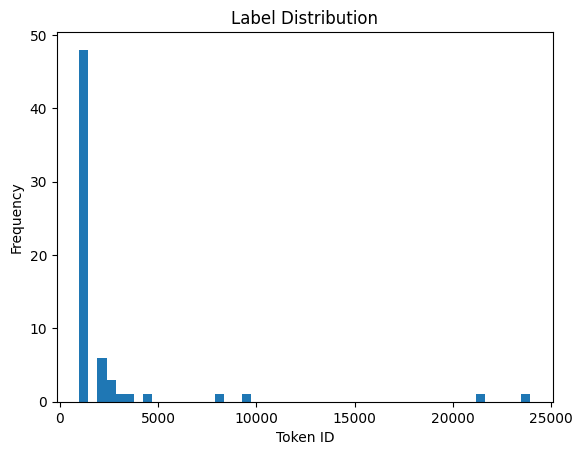

In [5]:
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

print(ds['train'][0])  # 샘플 데이터 확인

# 데이터 디버깅 코드 삽입
for batch in train_loader:
    texts, labels = batch

    # 텍스트 및 라벨 디코딩 확인
    decoded_texts = [tokenizer.decode(text) for text in texts[:2]]
    decoded_labels = [tokenizer.decode([label]) for label in labels[:2]]
    print("Original Texts:", decoded_texts)
    print("Labels (Last 2nd Word):", decoded_labels)

    # 라벨 분포 시각화 (한 번만 실행)
    all_labels = labels.tolist()
    plt.hist(all_labels, bins=50)
    plt.title("Label Distribution")
    plt.xlabel("Token ID")
    plt.ylabel("Frequency")
    plt.show()

    break  # 한 배치만 확인하고 중단

## 2. 모델 구현

### 2.1. SelfAttention Model

self-attention

In [6]:
class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

### 2.2. TransformerLayer Model

self-attention과 feed-forward layer를 구현한 모습

In [7]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

### 2.3. [MY_CODE] TextClassifier Model

TransformerLayer와 positional encoding을 모두 합친 모습

In [8]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size) #[MYCODE] 과제적용 출력차원을 1 -> vocab_size

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

## 3. Positional encoding

In [9]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(f"[LOG] {positional_encoding(max_len, 256).shape}")

[LOG] torch.Size([1, 400, 256])


## 4. [MY_CODE] 모델, 손실 함수, 옵티마이저 설정

In [10]:
print(f"[LOG] vocab_size : {len(tokenizer)}")

model = TextClassifier(len(tokenizer), 32, 2, 32)
lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() #[MYCODE] 과제적용 : 손실 함수 변경 이진 분류 -> 다중 클래스 분류

optimizer = Adam(model.parameters(), lr=lr)

[LOG] vocab_size : 30522


### 4.1. [MY_CODE] model의 정확도를 측정하는 함수

In [11]:
def accuracy(model, dataloader):
  model.eval()
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) #[MYCODE] 과제적용 : 손실 함수 변경 이진 분류 -> 다중 클래스 분류

    cnt += labels.shape[0]
    acc += (preds == labels).sum().item()

  return acc / cnt

### 4.2. [MY_CODE] plot 함수

In [12]:
def plot_acc(train_accs, test_accs, title, label1='train', label2='test'):
    """
    학습 정확도 및 테스트 정확도를 시각화하는 함수
    Args:
        train_accs: 각 epoch별 학습 정확도 리스트
        test_accs: 각 epoch별 테스트 정확도 리스트
        title: 그래프 제목
        label1: 학습 데이터 라벨
        label2: 테스트 데이터 라벨
    """
    plt.figure(figsize=(10, 5))
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(title)
    plt.show()

## 5. [MY_CODE] 학습

In [ ]:
# [MYCODE] 학습 루프에 정확도 및 손실 저장 추가
n_epochs = 5
train_acc_list = []
test_acc_list = []
train_loss_list = []

for epoch in range(n_epochs):
  epoch_start = time.time() #[MYCODE] 학습 시간 측정 시작
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs) #[MYCODE] 과제적용 : 손실 함수 변경 이진 분류 -> 다중 클래스 분류
    #[FEEDBACK] 기존 [..., 0] 제거하기 전에는 학습이 안되었음 둘의 차이점을 디버깅해봄
    #print(f"Preds Shape: {preds.shape}, Labels Shape: {labels.shape}")  # 디버깅
    #print(f"Preds Sample: {preds[0]}, Label Sample: {labels[0]}")  # 디버깅

    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  epoch_time = time.time() - epoch_start #[MYCODE] 학습 시간 측정 종료
  print(f"[LOG] Epoch {epoch + 1} | Train Loss: {total_loss:.4f} | Time: {epoch_time:.2f}s")

  eval_start_time = time.time()  #[MYCODE] 평가 시간 측정 시작

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    eval_time = time.time() - eval_start_time  #[MYCODE] 평가 시간 측정 종료
    print(f"[LOG] =========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f} | Time: {epoch_time:.2f}s")

    # [MYCODE] 정확도 저장
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

[LOG] Epoch 1 | Train Loss: 1515.7844 | Time: 31.63s
[LOG] =========> Train acc: 0.558 | Test acc: 0.564 | Time: 31.63s
[LOG] Epoch 2 | Train Loss: 1157.5772 | Time: 30.27s
[LOG] =========> Train acc: 0.558 | Test acc: 0.564 | Time: 30.27s
[LOG] Epoch 3 | Train Loss: 1125.6469 | Time: 30.59s
[LOG] =========> Train acc: 0.558 | Test acc: 0.564 | Time: 30.59s
[LOG] Epoch 4 | Train Loss: 1105.0729 | Time: 30.32s


## 5.1 [MY_CODE] 그래프 출력

In [ ]:
# [MYCODE] 학습 완료 후 그래프 출력
plot_acc(train_acc_list, test_acc_list, title="Train vs Test Accuracy")

## 6. 추가 작업

### 6.1. 드롭아웃 추가

In [ ]:
class TransformerLayerWithDropout(nn.Module):
    def __init__(self, input_dim, d_model, dff):
        super().__init__()
        self.sa = SelfAttention(input_dim, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model),
        )
        self.dropout = nn.Dropout(0.1)  # [Add] 드롭아웃 추가

    def forward(self, x, mask):
        x = self.sa(x, mask) + x
        x = self.ffn(x) + x
        x = self.dropout(x)  # [Add] 드롭아웃 적용
        return x

In [ ]:
class TextClassifierWithDropout(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayerWithDropout(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

### 6.2. 임베딩 차원 조정

In [ ]:
# 모델 초기화
model = TextClassifierWithDropout(len(tokenizer), 32, 2, 32)  # [Add] d_model=128, dff=256
model = model.to('cuda')

### 6.3. 학습률 스케줄러 추가

In [ ]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

### 6.4. 학습시작

In [ ]:
n_epochs = 2
train_acc_list, test_acc_list = [], []
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Test Accuracy")
plt.show()